In [2]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

## Discriminator

The discriminator for our GAN is going to be based off the architecture in the paper "Machine Learning Seismic Wave Discrimination: Application to Earthquake Early Warning" by Zefeng Li et al. In the paper, Li et al describe a discriminator that uses a stack of 1D convolutional layers and one fully connected layer to learn the features of p-waves. 
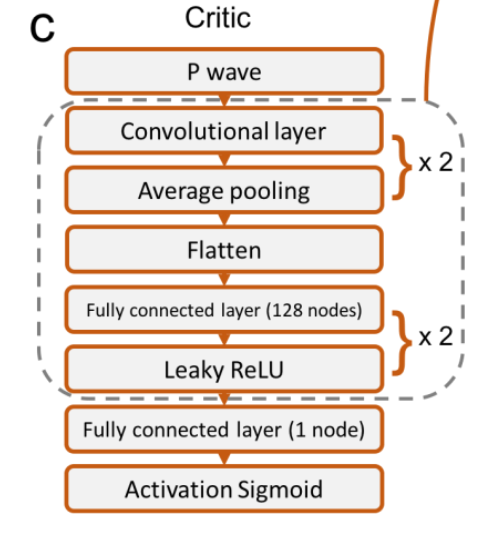

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolution layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        # Fully connected layer
        self.fc1 = nn.Linear(16 * 37, 128)
        # Output layer
        self.fc2 = nn.Linear(128, 1)
        
        self.avgpool = nn.AvgPool1d(kernel_size=2, stride=2)
        # Dropout for training. Set model to evaluation mode to turn off. 
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Input size has three dimensions - [batch_size, channels, time]
        x = x.view(x.shape[0], 1, -1)
        x = self.conv1(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = self.avgpool(x)
        # Reshape (flatten) tensor to pass through fully 
        # connected layer
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

## Generator
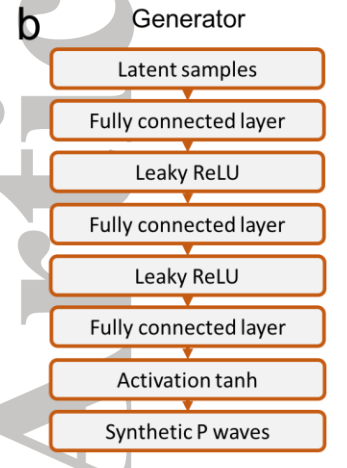

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 600)
        
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = torch.tanh(self.fc3(x))
        
        return x

In [5]:
import h5py

traindata = h5py.File("../train/scsn_p_2000_2017_6sec_0.5r_pick_train.hdf5")
testdata = h5py.File("../test/scsn_p_2000_2017_6sec_0.5r_pick_test.hdf5")

In [6]:
from torch.utils.data import DataLoader

# Load test data
trainset = traindata["X"]
testset = testdata["X"]

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

In [7]:
batch = next(iter(testloader))
batch.shape

torch.Size([32, 600])

In [8]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [9]:
gen = Generator()

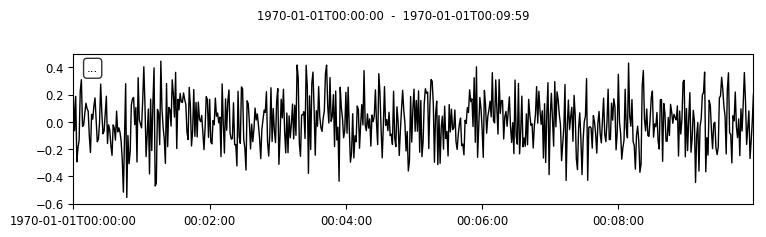

In [15]:
from obspy.core.trace import Trace
# Fake waveform generated before training
with torch.no_grad():
    batch = torch.randn(32, 50)
    fake_waveforms = gen.forward(batch)

    sample = fake_waveforms[0].numpy()
    sample = Trace(sample)
    sample.plot()

In [10]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    global device
    labels = labels.to(device)
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    global device
    
    labels = labels.to(device)
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [11]:
from torch import optim

d_optimizer = optim.Adam(critic.parameters(), lr=0.001)
g_optimizer = optim.Adam(gen.parameters(), lr=0.001) 

In [12]:
critic.to(device)
gen.to(device)

epochs = 100

train_losses = []
validation_losses = []

latent_size = 50

batch_i = 0
print_every = 200

for epoch in range(epochs):
    gen.train()
    critic.train()
    
    for batch in testloader:
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        batch = batch.to(device)
        
        d_optimizer.zero_grad()
        # Feed real image through discriminator
        d_real = critic.forward(batch)
        # Calculate loss
        d_real_loss = real_loss(d_real)
        # Feed fake image through discriminator
        latent = np.random.uniform(-1, 1, size=(batch.shape[0], latent_size))
        latent = torch.from_numpy(latent).float()
        latent = latent.to(device)
        
        fake_images = gen.forward(latent)
        
        d_fake = critic.forward(fake_images)
        d_fake_loss = fake_loss(d_fake)
        # Add fake + real loss
        d_loss = d_fake_loss + d_real_loss
        # Backpropagate changes through the network
        d_loss.backward()
        # Update weights in optimizer
        d_optimizer.step()
        
        # ============================================
        #            TRAIN THE GENERATOR
        # ============================================
        
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        latent = np.random.uniform(-1, 1, size=(batch.shape[0], latent_size))
        latent = torch.from_numpy(latent).float()
        latent = latent.to(device)
        
        fake_images = gen.forward(latent)
        
        d_fake = critic.forward(fake_images)
        g_loss = real_loss(d_fake)
        
        # Perform backprop
        g_loss.backward()
        g_optimizer.step()
        
        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, epochs, d_loss.item(), g_loss.item()))
            
        batch_i += 1
        

Epoch [    1/  100] | d_loss: 1.3858 | g_loss: 0.6997
Epoch [    1/  100] | d_loss: 2.0048 | g_loss: 0.5429
Epoch [    1/  100] | d_loss: 0.8227 | g_loss: 1.9067
Epoch [    1/  100] | d_loss: 1.1378 | g_loss: 1.5657
Epoch [    1/  100] | d_loss: 1.3628 | g_loss: 0.6201
Epoch [    1/  100] | d_loss: 1.2401 | g_loss: 1.3417
Epoch [    1/  100] | d_loss: 1.0402 | g_loss: 1.3463
Epoch [    1/  100] | d_loss: 0.7394 | g_loss: 2.1164
Epoch [    1/  100] | d_loss: 1.0284 | g_loss: 1.7970
Epoch [    1/  100] | d_loss: 0.7504 | g_loss: 2.6439
Epoch [    1/  100] | d_loss: 0.7970 | g_loss: 1.6884
Epoch [    1/  100] | d_loss: 2.3586 | g_loss: 0.4464
Epoch [    1/  100] | d_loss: 1.0156 | g_loss: 1.7138
Epoch [    1/  100] | d_loss: 0.6057 | g_loss: 1.3214
Epoch [    1/  100] | d_loss: 1.2520 | g_loss: 0.9725
Epoch [    1/  100] | d_loss: 0.8716 | g_loss: 5.8824
Epoch [    1/  100] | d_loss: 0.9491 | g_loss: 1.1628
Epoch [    1/  100] | d_loss: 0.1002 | g_loss: 10.8754
Epoch [    1/  100] | d_los

KeyboardInterrupt: 

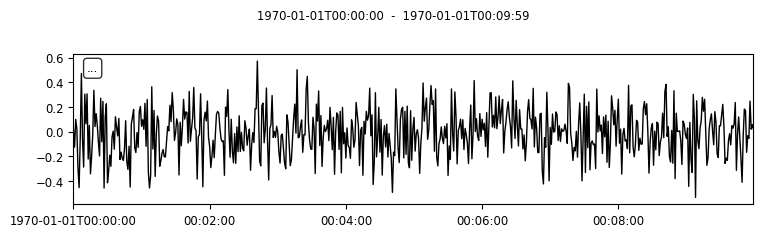

In [13]:
# TODO - Add validation with 20% of training data
# Train with training set
# Train discriminator at x times the amount of the generator
with torch.no_grad():
    batch = torch.randn(32, 50)
    fake_waveforms = gen.forward(batch)

    sample = fake_waveforms[0].numpy()
    sample = Trace(sample)
    sample.plot()